In [441]:
import os
import glob
from IPython.display import Image, Audio, display

import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [442]:
tf.test.gpu_device_name()

''

In [443]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [444]:
bons = [os.path.join('/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/',os.path.basename(a).replace('.png','.mp3')) for a in glob.glob('/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/bons/*.png')]

for b in bons:
    display(b)
    display(Audio(b))

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00393.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00111.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00028.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00083.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00376.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00073.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00397.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00183.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00115.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00133.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00112.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00180.mp3'

'/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset/MP3/a00443.mp3'

In [445]:
def add_white_noise(x, rate=0.012):
    return x + rate*np.random.randn(len(x))

def time_shift(x, rate=1.5):
    return np.roll(x, int(len(x)//rate))

def reverse(x):
    return x[::-1]

In [451]:
import librosa

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import random

dados = []
for b in tqdm(bons):
    nome = os.path.basename(b)[:-4]
    y, sr = librosa.load(b)
    x = np.arange(len(y))/sr


    # Data augmentation
    y_noise = add_white_noise(y)
    y_shift = time_shift(y)
    y_reverse = reverse(y)

    x_noise = np.arange(len(y_noise))/sr
    x_shift = np.arange(len(y_shift))/sr
    x_reverse = np.arange(len(y_reverse))/sr

    janela = int(0.4 * sr)
    passo = int(0.15 * sr)

    original = []
    shifted = []
    noisy = []
    reversed = []
    for i in range(0, len(y), int(passo)):
        max = i + janela
        if max > len(y):
            break
        original.append((x[i:max], y[i:max]))

        # Data augmentation
        shifted.append((x_shift[i:max], y_shift[i:max]))
        noisy.append((x_noise[i:max], y_noise[i:max]))
        reversed.append((x_reverse[i:max], y_reverse[i:max]))


    dados.append(original)
    dados.append(shifted)
    dados.append(noisy)
    dados.append(reversed)

100%|██████████| 13/13 [00:00<00:00, 21.29it/s]


In [452]:
def plot_wave(option: int = 0):
  fig, ax = plt.subplots(len(dados) // 4, 1, figsize=(15, len(dados)))
  for i in range(option, len(dados) - 1, 4):
      index = i // 4
      linha = dados[i]
      ax[index].set_title(bons[index].split('/')[-1])
      for x, y in linha:
          ax[index].plot(x, y)
  plt.show()

Plot the original waves

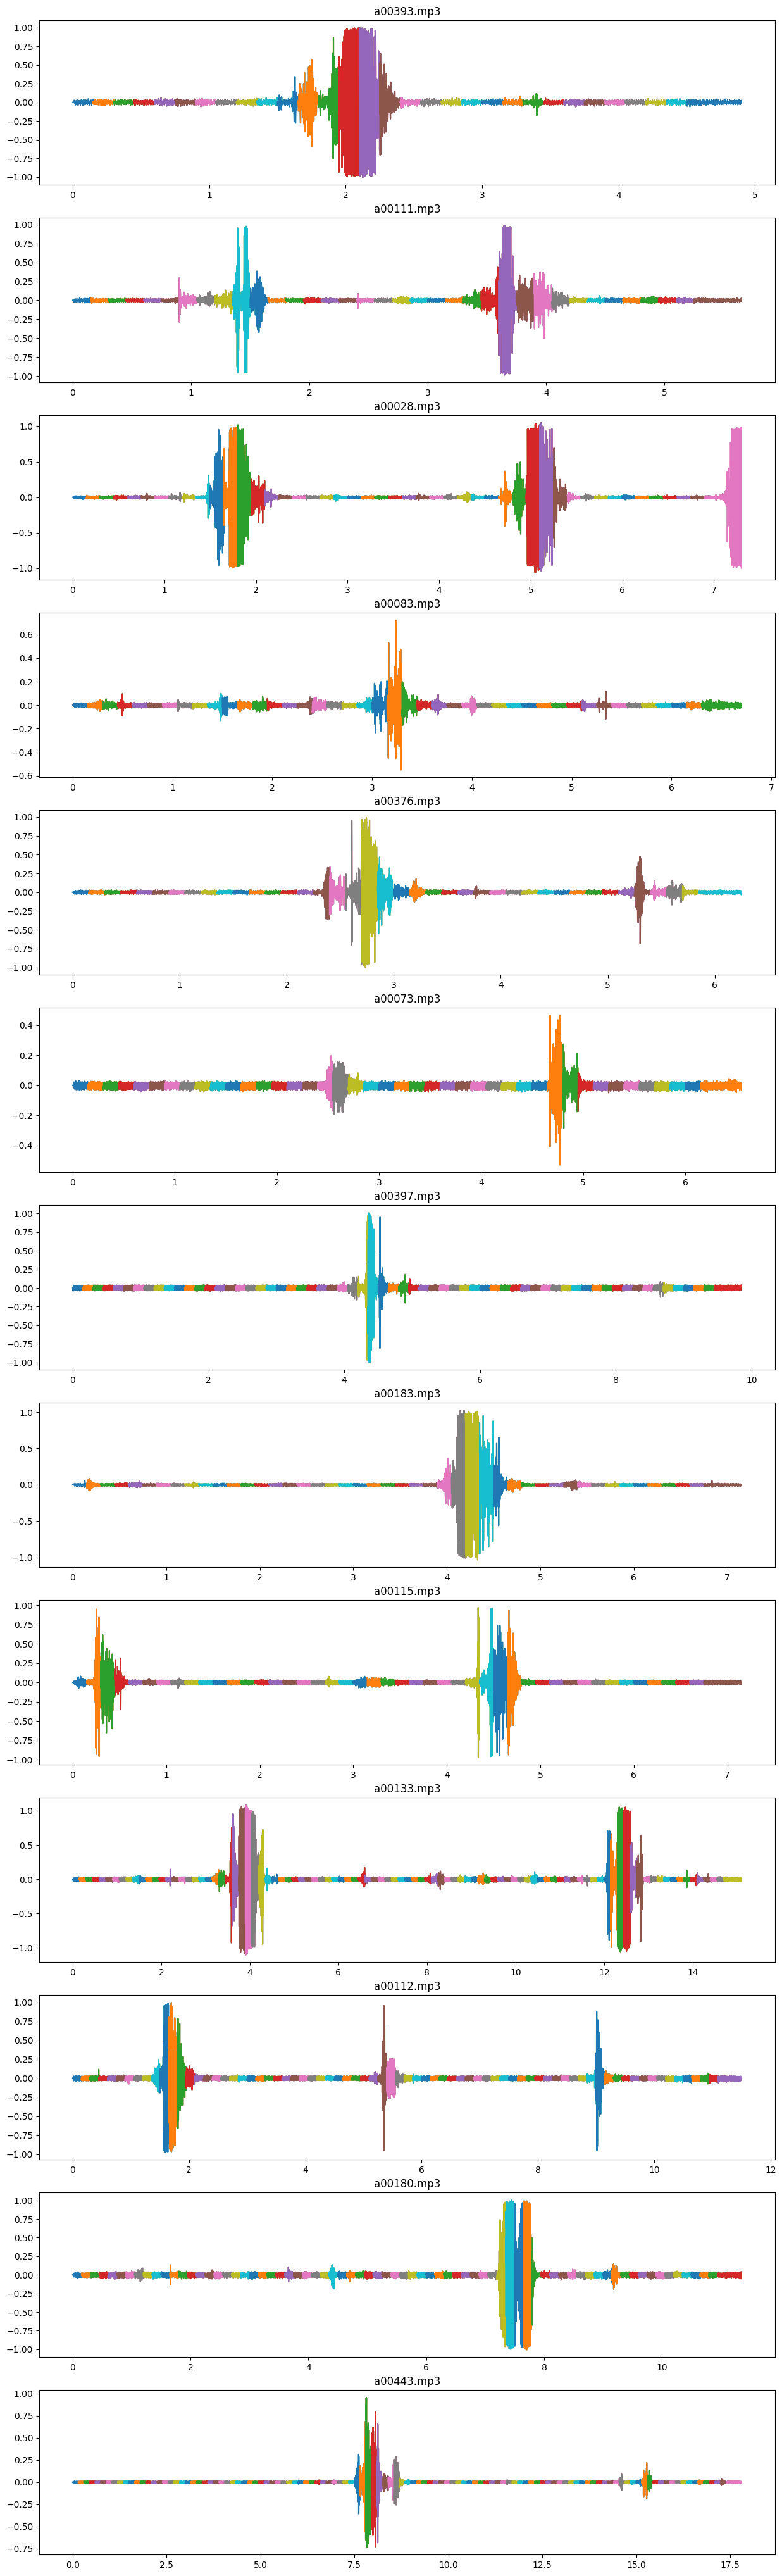

In [453]:
plot_wave()

Plot the shift waves

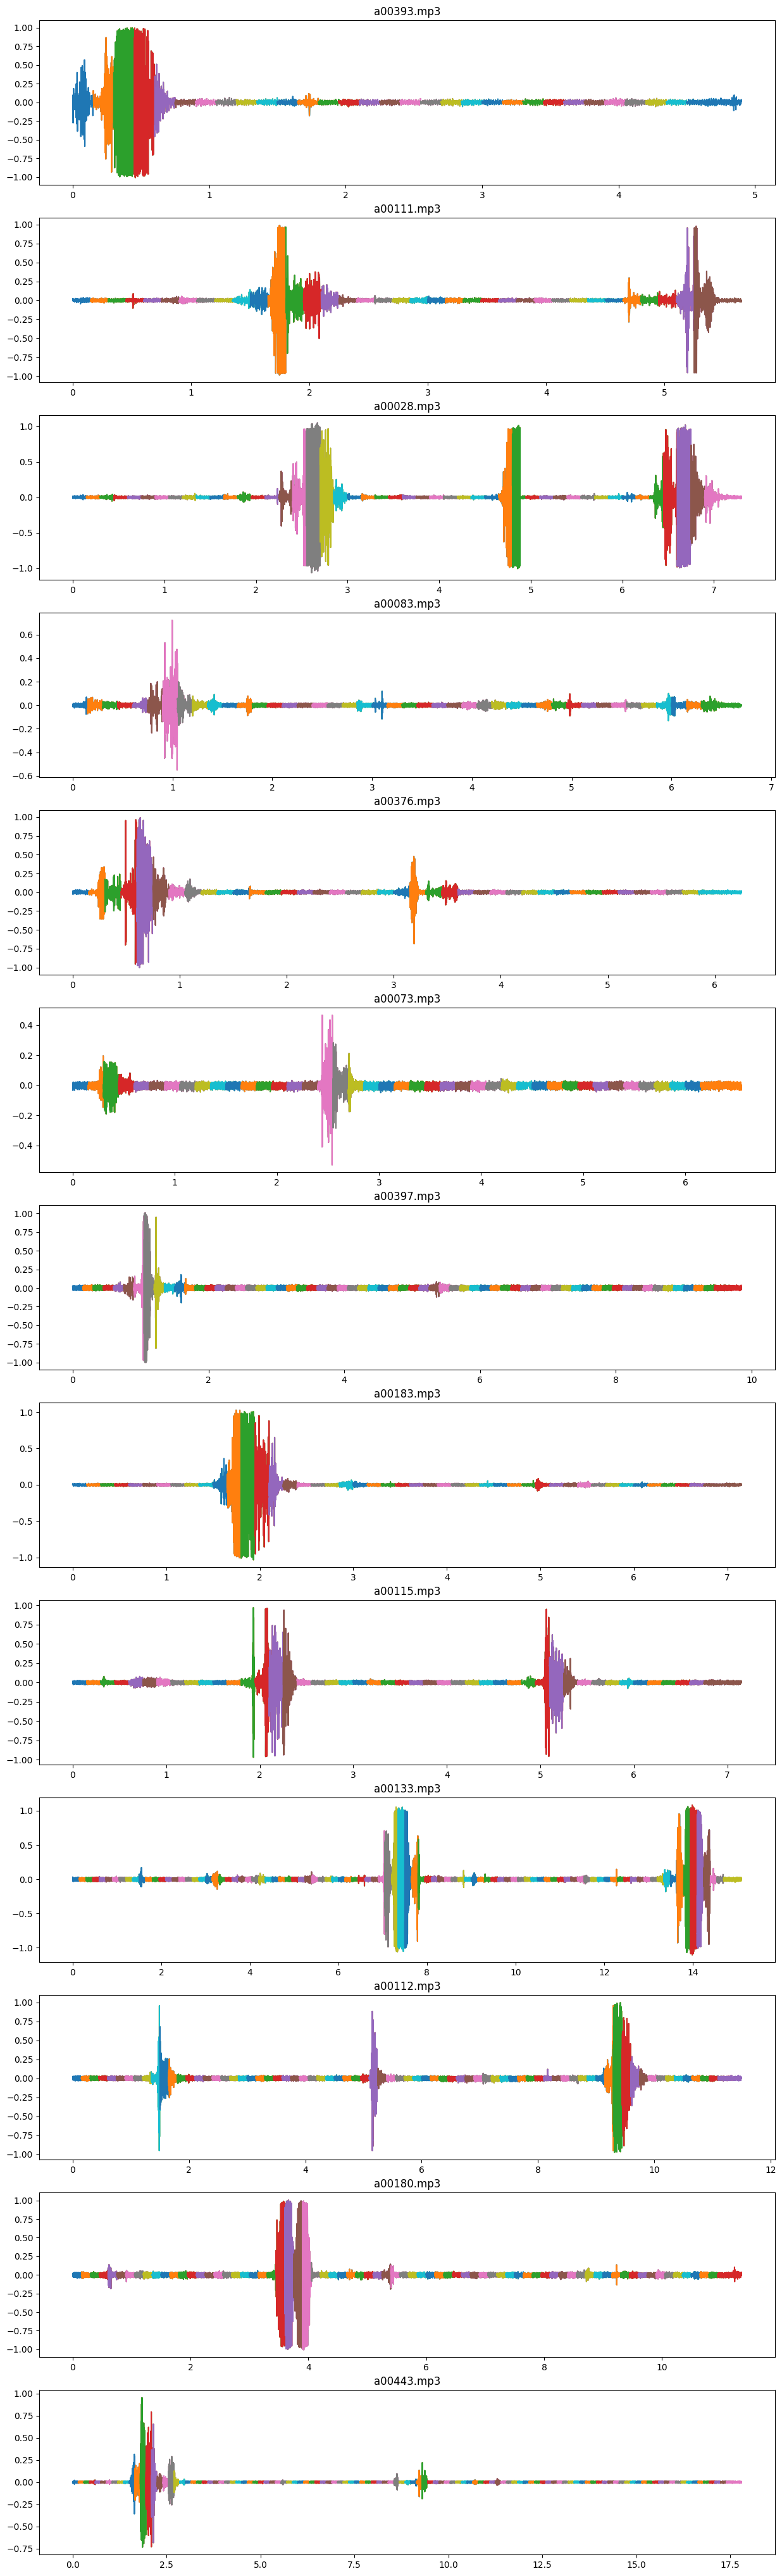

In [454]:
plot_wave(1)

Plot the noisy waves

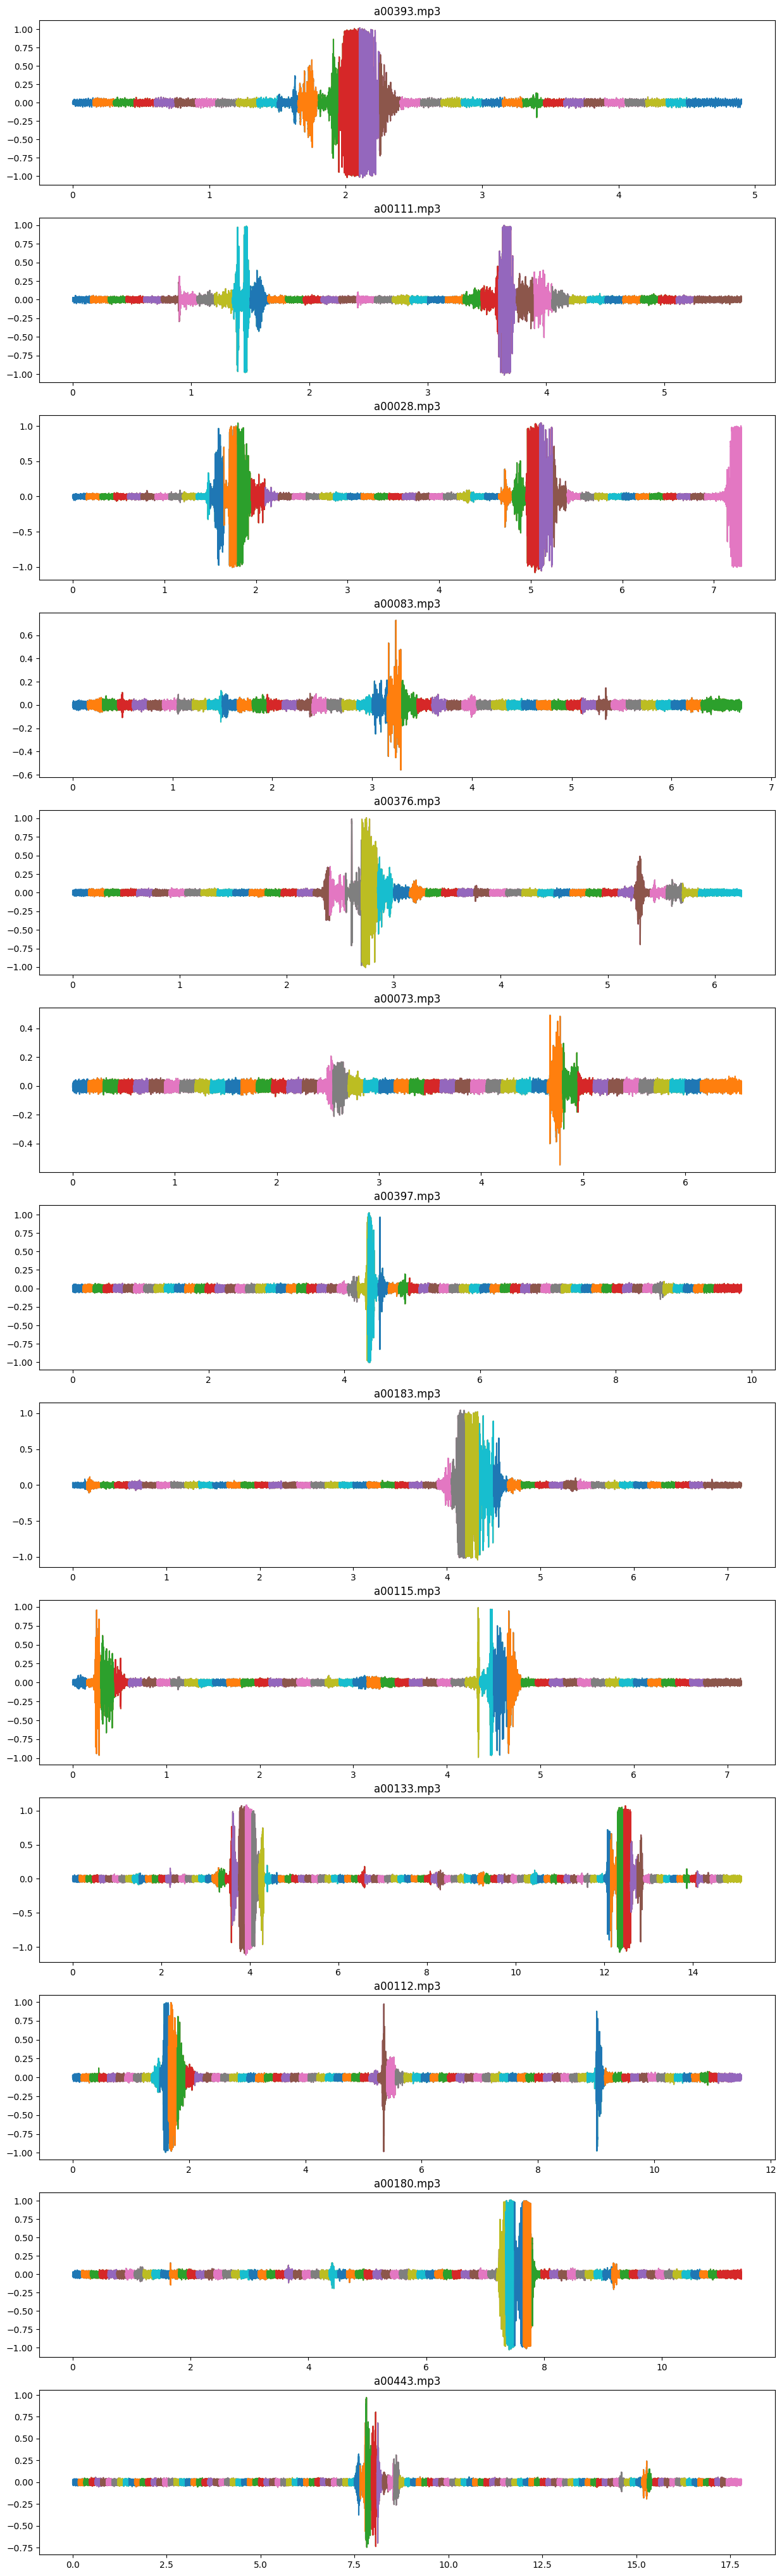

In [561]:
plot_wave(2)

Plot the reverse wave

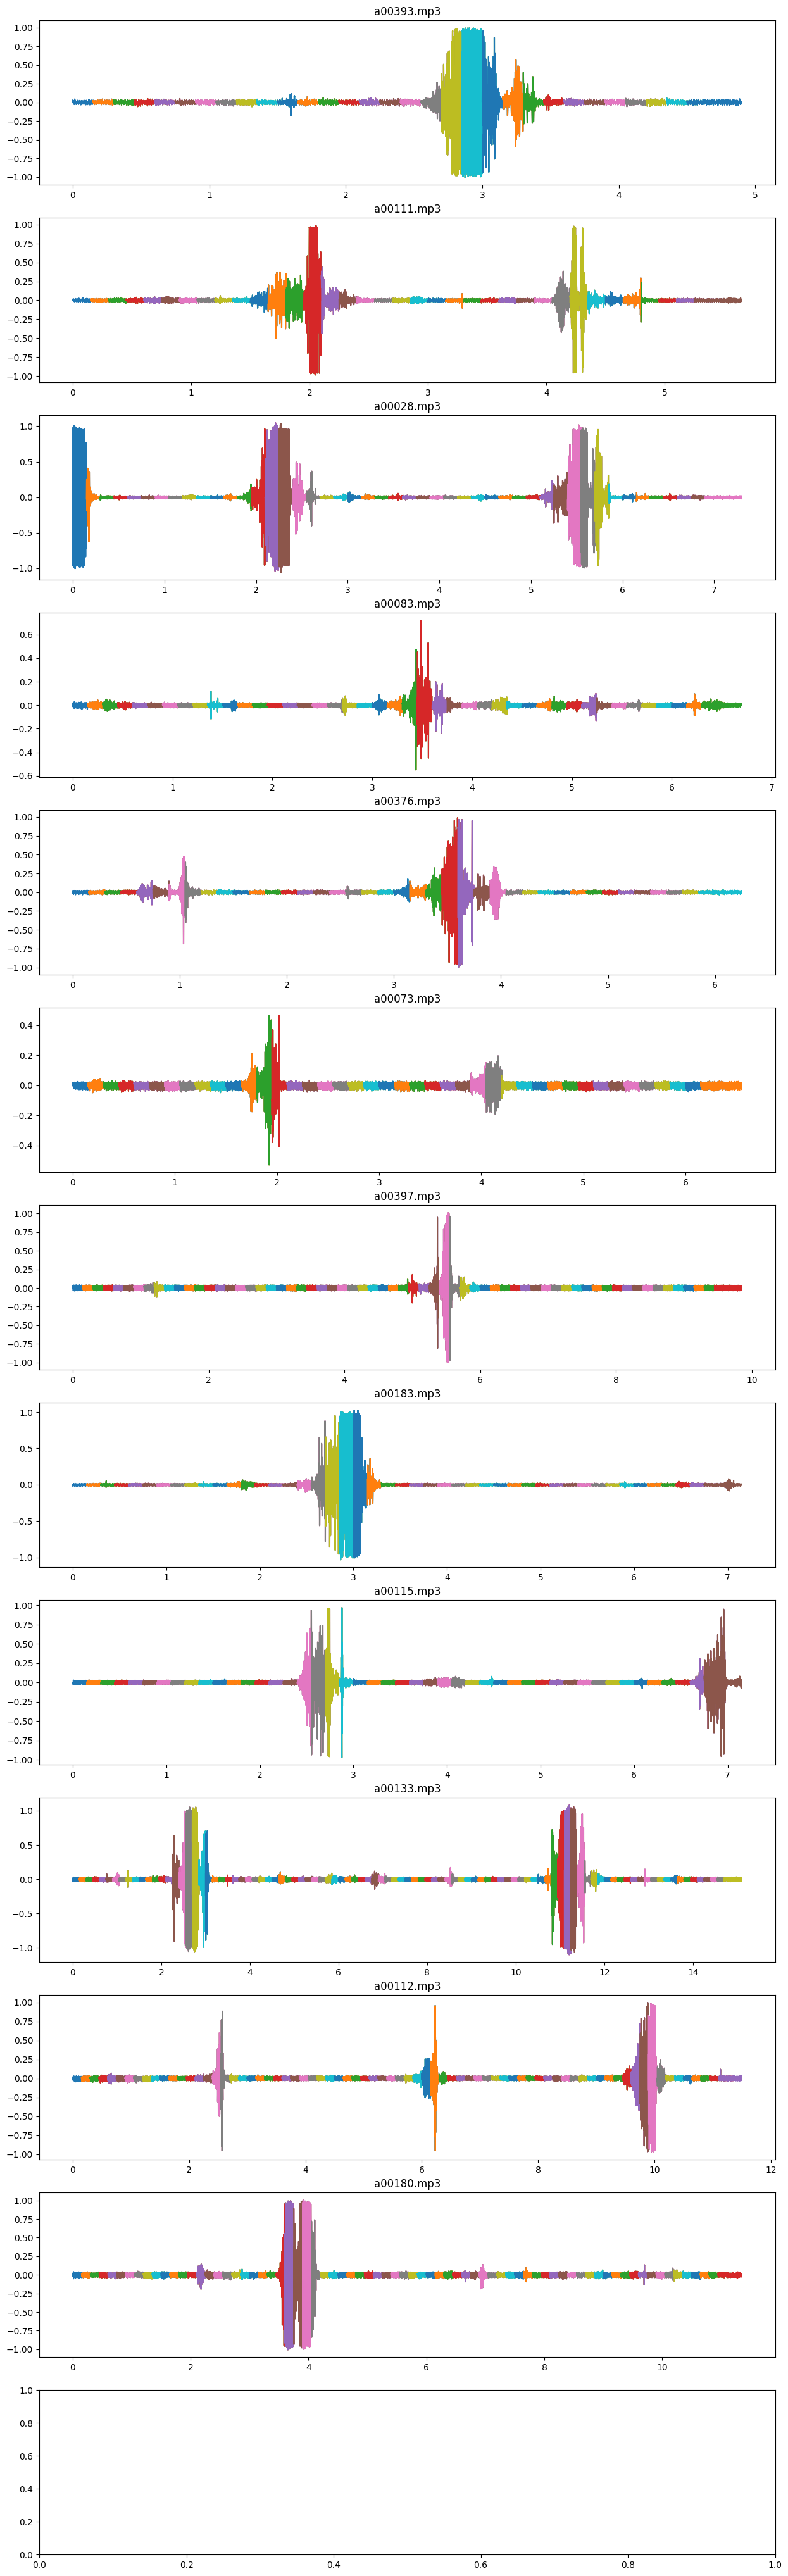

In [562]:
plot_wave(3)

## LocalOutlierFactor to swalling detect

In [455]:
X = []
for i, linha in enumerate(dados):
    for _, y in linha:
        X.append(y)

In [456]:
X = np.array(X)
X.shape

(3040, 8820)

In [458]:
#clf = IsolationForest(contamination=0.15)
clf = LocalOutlierFactor(contamination=0.1, novelty=True)

In [459]:
clf.fit(X)
pred = clf.predict(X)
pred = (pred == -1)

In [460]:
pred = pred.astype(np.float32)

In [461]:
pred.shape

(3040,)

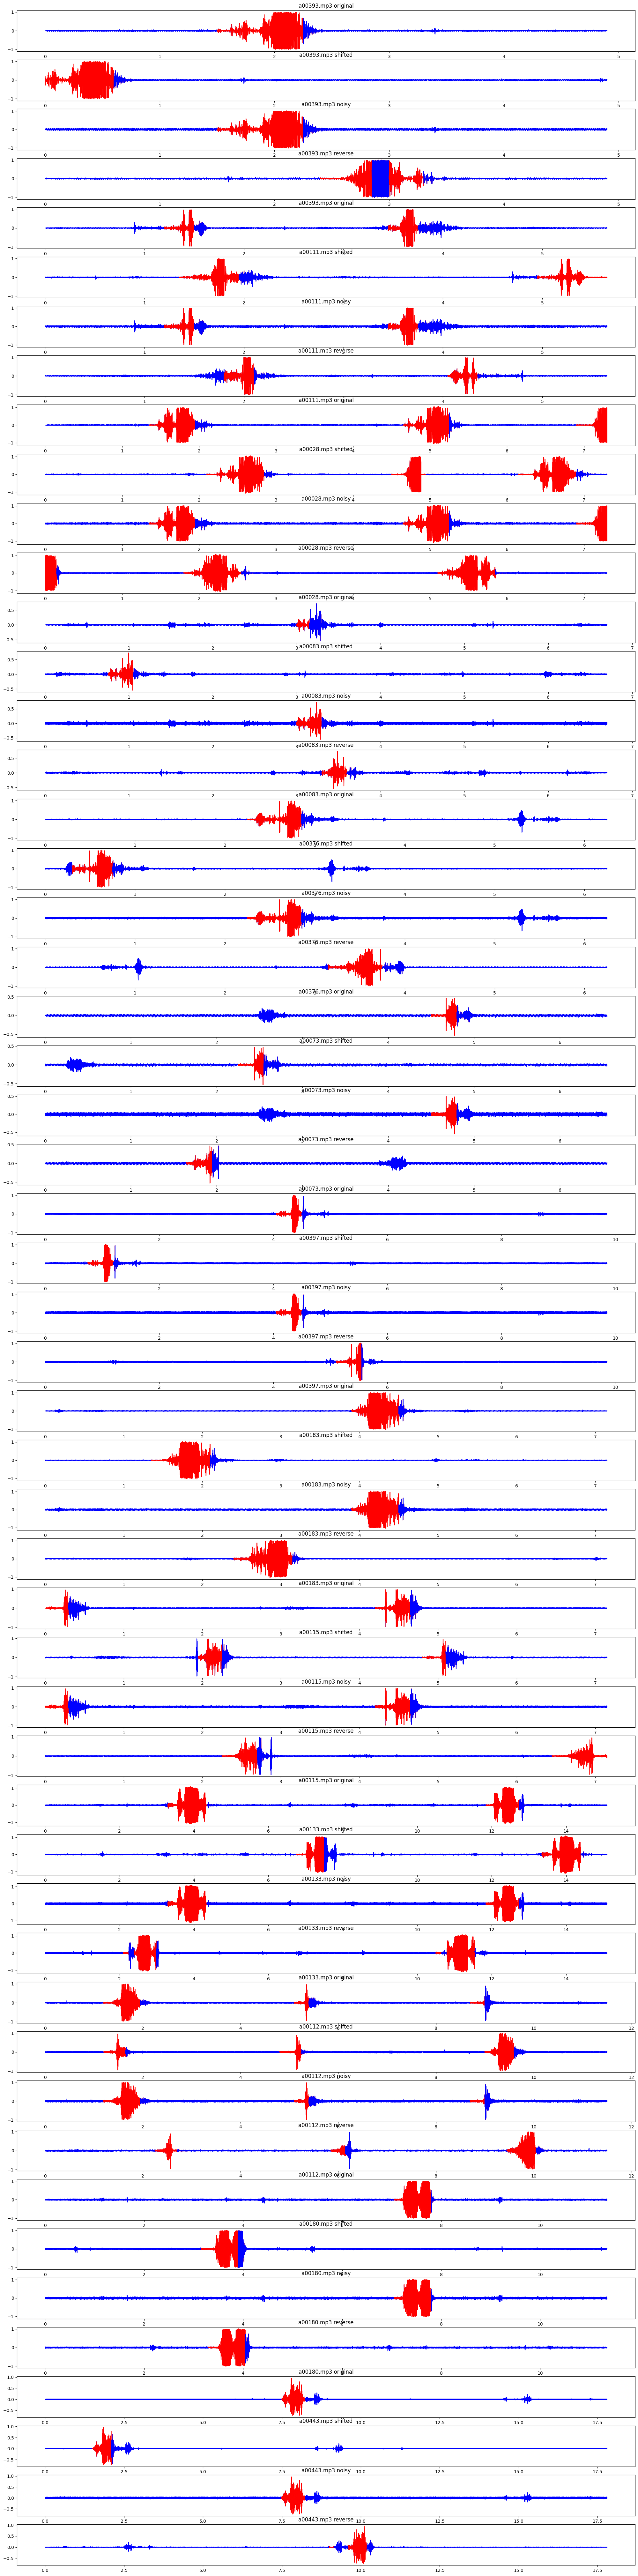

In [504]:
fig, ax = plt.subplots(len(dados), 1, figsize=(25, len(dados)*2))

label_index = 0
name_index = 0
typ = [' original', ' shifted', ' noisy', ' reverse']

for i in range(0, len(dados), 1):
    #print(name_index, bons[name_index].split('/')[-1])
    ax[i].set_title(bons[name_index].split('/')[-1] + typ[i % 4])
    for x, y in dados[i]:
        ax[i].plot(x, y, color='red' if pred[label_index] else 'blue')
        label_index+=1

    if (i % 4 == 0) and (i != 0) and (name_index < len(bons)):
        name_index += 1

plt.show()

## Dataset preprocessing

In [122]:
# from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE

# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X, pred)

In [ ]:
# X_resampled.shape

**I tested performing data augmentation artificially with the SMOTE, ADASYN and RemoteOverSampler techniques, which significantly increased the amount of data, but generated a failure in my models, where the validation data had higher scores than the training data, from the beginning to the end. Furthermore, due to this inconsistency, the scores indicated an excellent model, but in practice they were not making such adequate classifications. So I chose to directly use the available data, even with a high imbalance between classes 0 and 1**

In [526]:
X_train, X_test, y_train, y_test = train_test_split(X, pred, test_size=0.2)

In [527]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2432, 8820)
X_test shape: (608, 8820)
y_train shape: (2432,)
y_test shape: (608,)


## Deep learning Model

In [515]:
def plot_metrics(history, model, X, y):
    # Create a figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the training and validation accuracy
    axs[0].plot(history.history['f1_score'])
    axs[0].plot(history.history['val_f1_score'])
    axs[0].set_title('Model F1 Score')
    axs[0].set_ylabel('F1')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot the training and validation loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Show the plot
    plt.show()

    # Print the classification report
    y_pred = model.predict(X)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
    print(classification_report(y, y_pred_binary))

## Conv Model

In [530]:

conv_model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1],)),
        layers.Reshape((X_train.shape[1], 1)),
        layers.Conv1D(filters=4, kernel_size=2, padding="same", activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ]
)
conv_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 8820, 1)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 8820, 4)           12        
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 4410, 4)           0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 4410, 4)           0         
                                                                 
 flatten_8 (Flatten)         (None, 17640)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17641     
                                                      

In [531]:
conv_model.compile(
    optimizer="sgd",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.F1Score(threshold=0.5)],
)

conv_history = conv_model.fit(X_train, y_train, epochs=12, validation_data=(X_test, y_test), batch_size=42)

Epoch 1/12
58/58 [==============================] - 12s 172ms/step - loss: 0.6275 - f1_score: 0.6555 - val_loss: 0.5723 - val_f1_score: 0.8906
Epoch 2/12
58/58 [==============================] - 6s 108ms/step - loss: 0.5293 - f1_score: 0.8904 - val_loss: 0.4921 - val_f1_score: 0.9256
Epoch 3/12
58/58 [==============================] - 9s 147ms/step - loss: 0.4582 - f1_score: 0.8961 - val_loss: 0.4305 - val_f1_score: 0.9076
Epoch 4/12
58/58 [==============================] - 5s 90ms/step - loss: 0.4027 - f1_score: 0.8951 - val_loss: 0.3820 - val_f1_score: 0.8870
Epoch 5/12
58/58 [==============================] - 6s 111ms/step - loss: 0.3585 - f1_score: 0.8831 - val_loss: 0.3430 - val_f1_score: 0.8673
Epoch 6/12
58/58 [==============================] - 6s 101ms/step - loss: 0.3217 - f1_score: 0.9031 - val_loss: 0.3112 - val_f1_score: 0.8571
Epoch 7/12
58/58 [==============================] - 5s 93ms/step - loss: 0.2929 - f1_score: 0.8846 - val_loss: 0.2848 - val_f1_score: 0.8571
Epoch 8

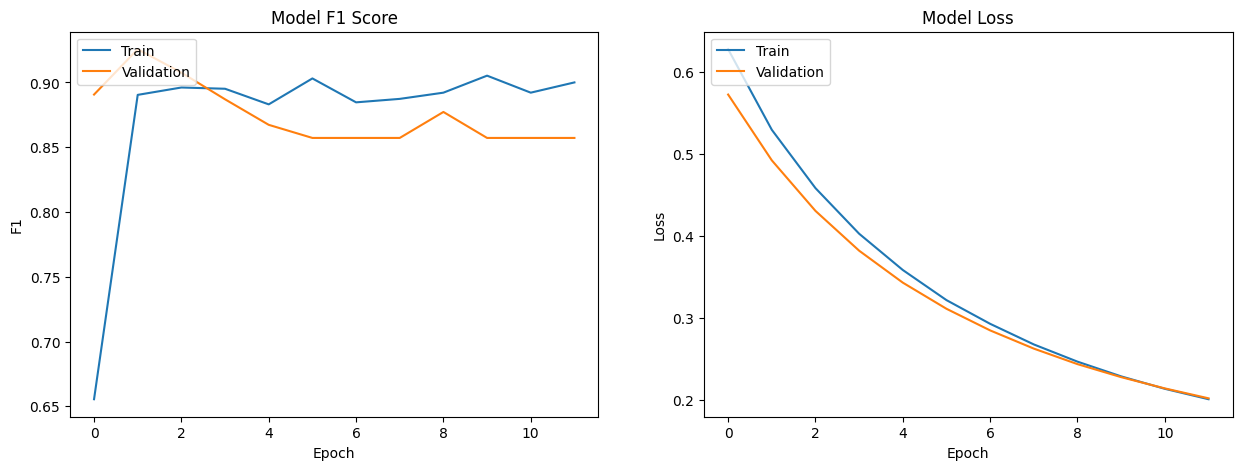

19/19 [==============================] - 1s 29ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       547
         1.0       0.94      0.79      0.86        61

    accuracy                           0.97       608
   macro avg       0.96      0.89      0.92       608
weighted avg       0.97      0.97      0.97       608



In [532]:
plot_metrics(conv_history, conv_model, X_test, y_test)

## RNN Model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 8820, 1)           0         
                                                                 
 lstm_3 (LSTM)               (None, 8820, 4)           96        
                                                                 
 dropout_11 (Dropout)        (None, 8820, 4)           0         
                                                                 
 flatten_11 (Flatten)        (None, 35280)             0         
                                                                 
 dense_11 (Dense)            (None, 1)                 35281     
                                                                 
Total params: 35377 (138.19 KB)
Trainable params: 35377 (138.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
38/38

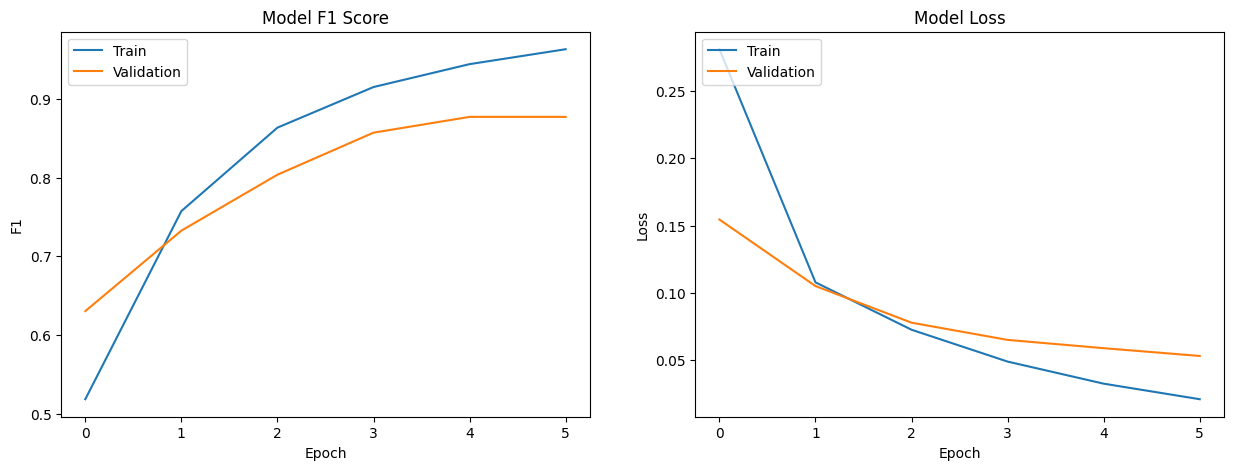

19/19 [==============================] - 10s 497ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       547
         1.0       0.94      0.82      0.88        61

    accuracy                           0.98       608
   macro avg       0.96      0.91      0.93       608
weighted avg       0.98      0.98      0.98       608



In [535]:
rnn_model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1],)),
        layers.Reshape((X_train.shape[1], 1)),
        layers.LSTM(4, return_sequences=True),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ]
)
rnn_model.summary()

rnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.F1Score(threshold=0.5)],
)

rnn_history = rnn_model.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), batch_size=64)

plot_metrics(rnn_history, rnn_model, X_test, y_test)

## MLP Model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 8820)]            0         
                                                                 
 dense_20 (Dense)            (None, 8)                 70568     
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 70577 (275.69 KB)
Trainable params: 70577 (275.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
76/76 [==============================] - 3s 17ms/step - loss: 0.6483 - f1_score: 0.4226 - val_loss: 0.5757 - val_f1_score: 0.6281
Epoch 2/10
7

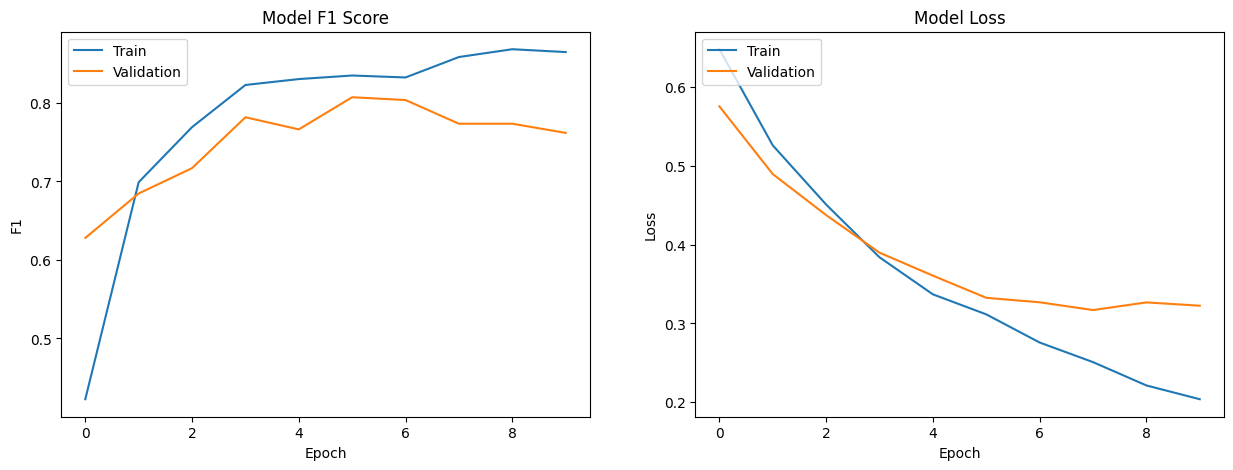

19/19 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       547
         1.0       0.91      0.66      0.76        61

    accuracy                           0.96       608
   macro avg       0.94      0.82      0.87       608
weighted avg       0.96      0.96      0.96       608



In [539]:
inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(8, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

mlp_model = keras.Model(inputs, outputs)
mlp_model.summary()

mlp_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.F1Score(threshold=0.5)])
mlp_history = mlp_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)
plot_metrics(mlp_history, mlp_model, X_test, y_test)

## Test models

In [540]:
dataset_valid_files = [f for f in os.listdir("/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/test/valid") if f.endswith('.mp3')]

In [542]:
test_data = []
for b in tqdm(dataset_valid_files):
    nome = os.path.basename(b)[:-4]
    y, sr = librosa.load("/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/test/valid/" + b)
    x = np.arange(len(y))/sr

    janela = int(0.4 * sr)
    passo = int(0.15 * sr)

    linha = []
    for i in range(0, len(y), int(passo)):
        max = i + janela
        if max > len(y):
            break
        linha.append((x[i:max], y[i:max]))
    test_data.append(linha)

100%|██████████| 6/6 [00:00<00:00, 30.10it/s]


### Plot the classification
The toggle button enable to chose between mlp, rnn and cnn model and plot the classification on test data

In [547]:
import ipywidgets as widgets
from ipywidgets import ToggleButtons
import matplotlib.pyplot as plt
import os

# Define a function to plot the prediction based on the selected model and save it as an image
def plot_and_save_prediction(model, model_name):
    fig, ax = plt.subplots(len(test_data), 1, figsize=(15, 3*len(test_data)))
    n=-1
    for i, linha in enumerate(test_data):
        ax[i].set_title(bons[i].split('/')[-1])
        for x, y in linha:
            n+=1
            ax[i].plot(x, y, color='red' if model.predict(y.reshape(1, -1), verbose=0)[0][0] > 0.5 else 'blue')
    plt.savefig(f'{model_name}_prediction.png')
    plt.close()

# Generate and save the prediction plots for each model
plot_and_save_prediction(mlp_model, 'mlp_model')
plot_and_save_prediction(rnn_model, 'rnn_model')
plot_and_save_prediction(conv_model, 'conv_model')

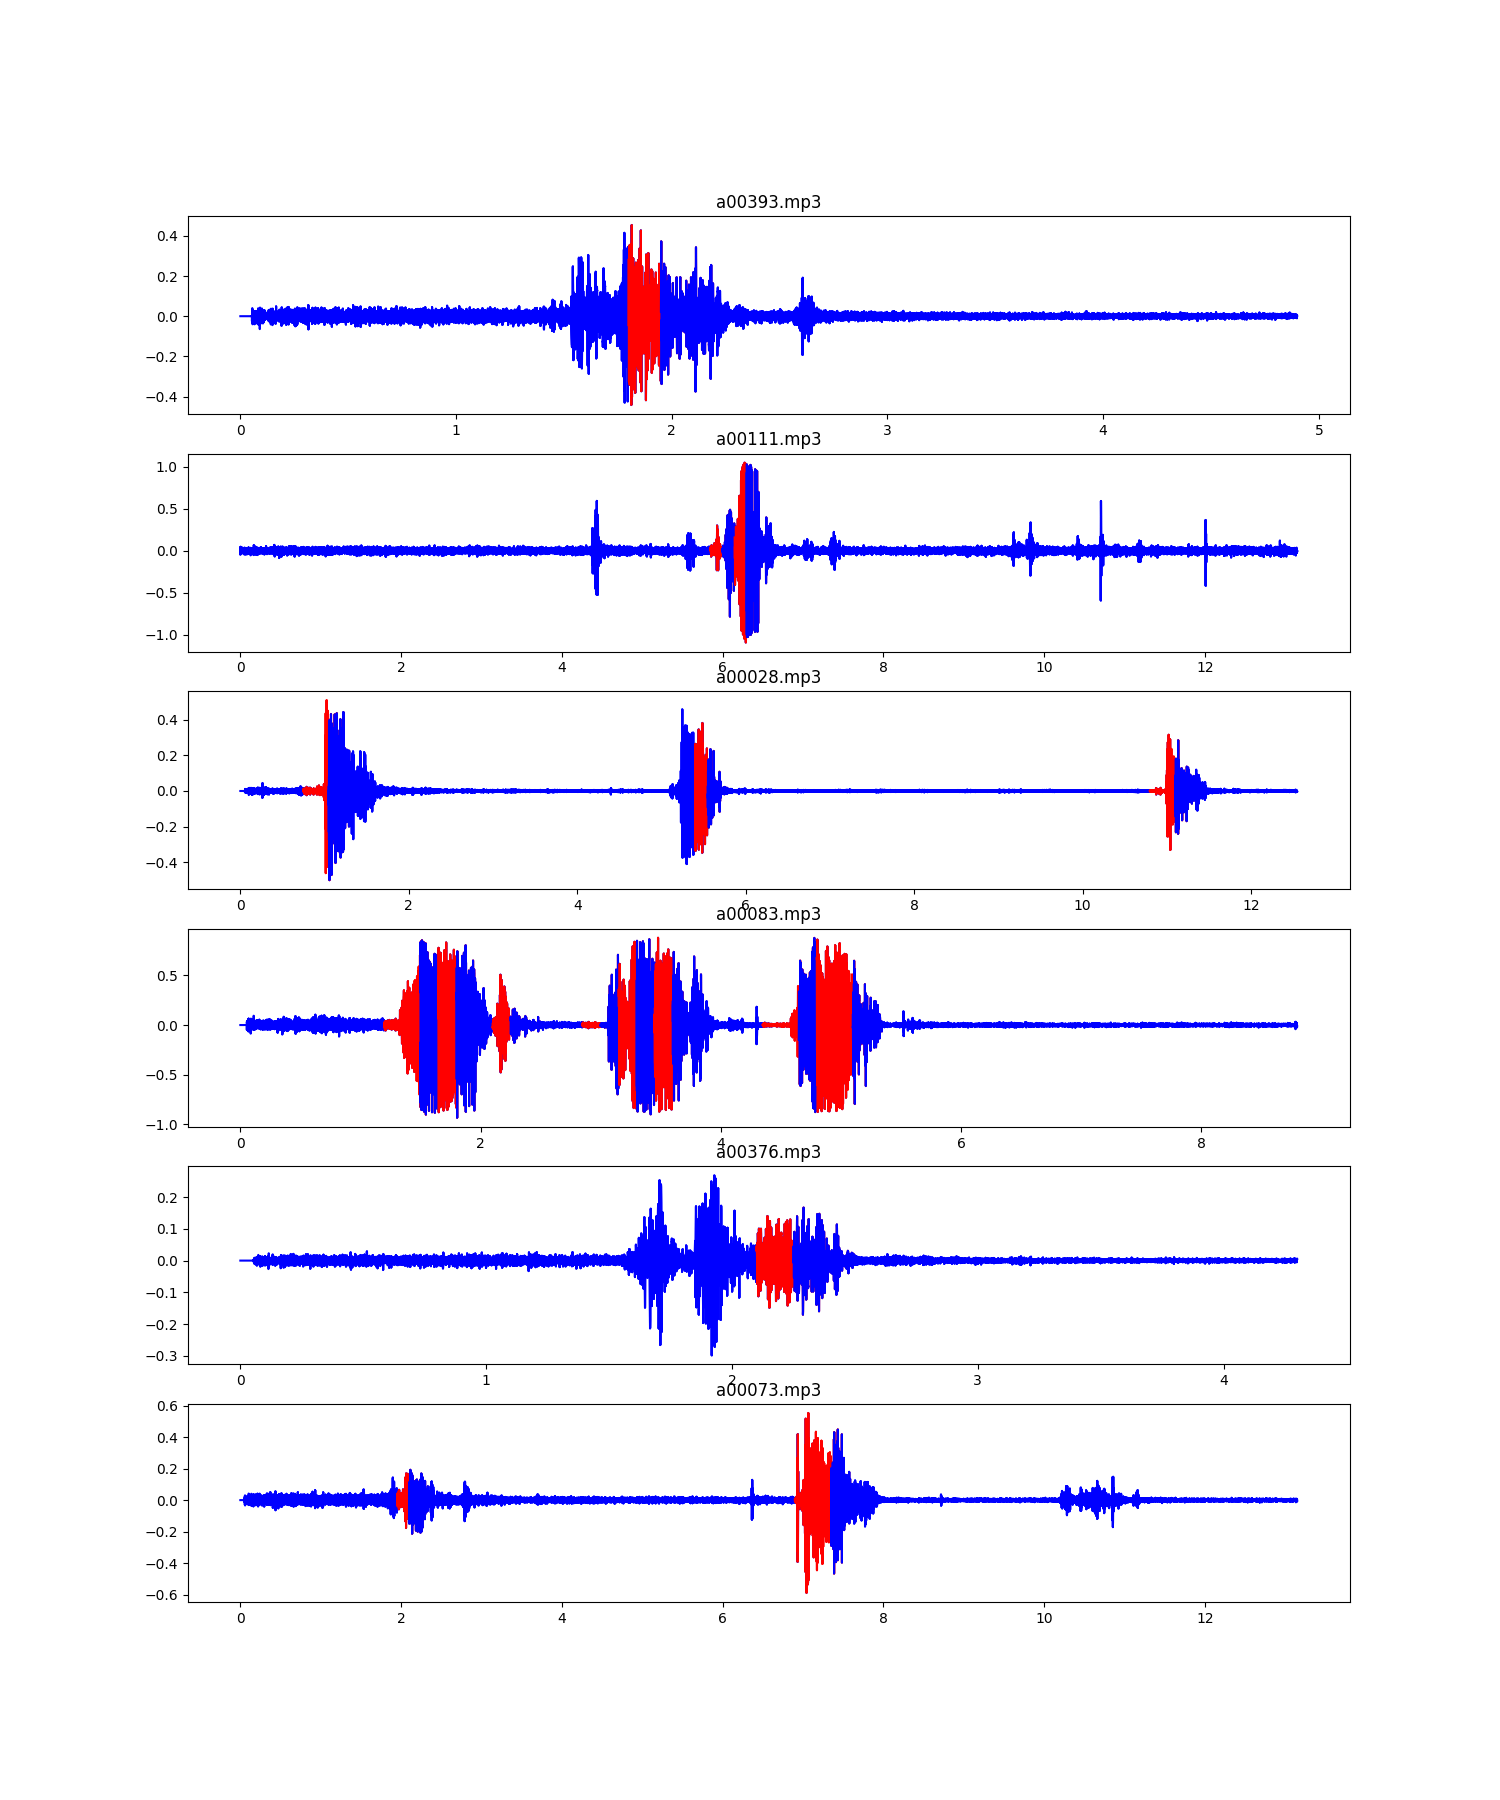

In [558]:
display(Image(filename='mlp_model_prediction.png'))

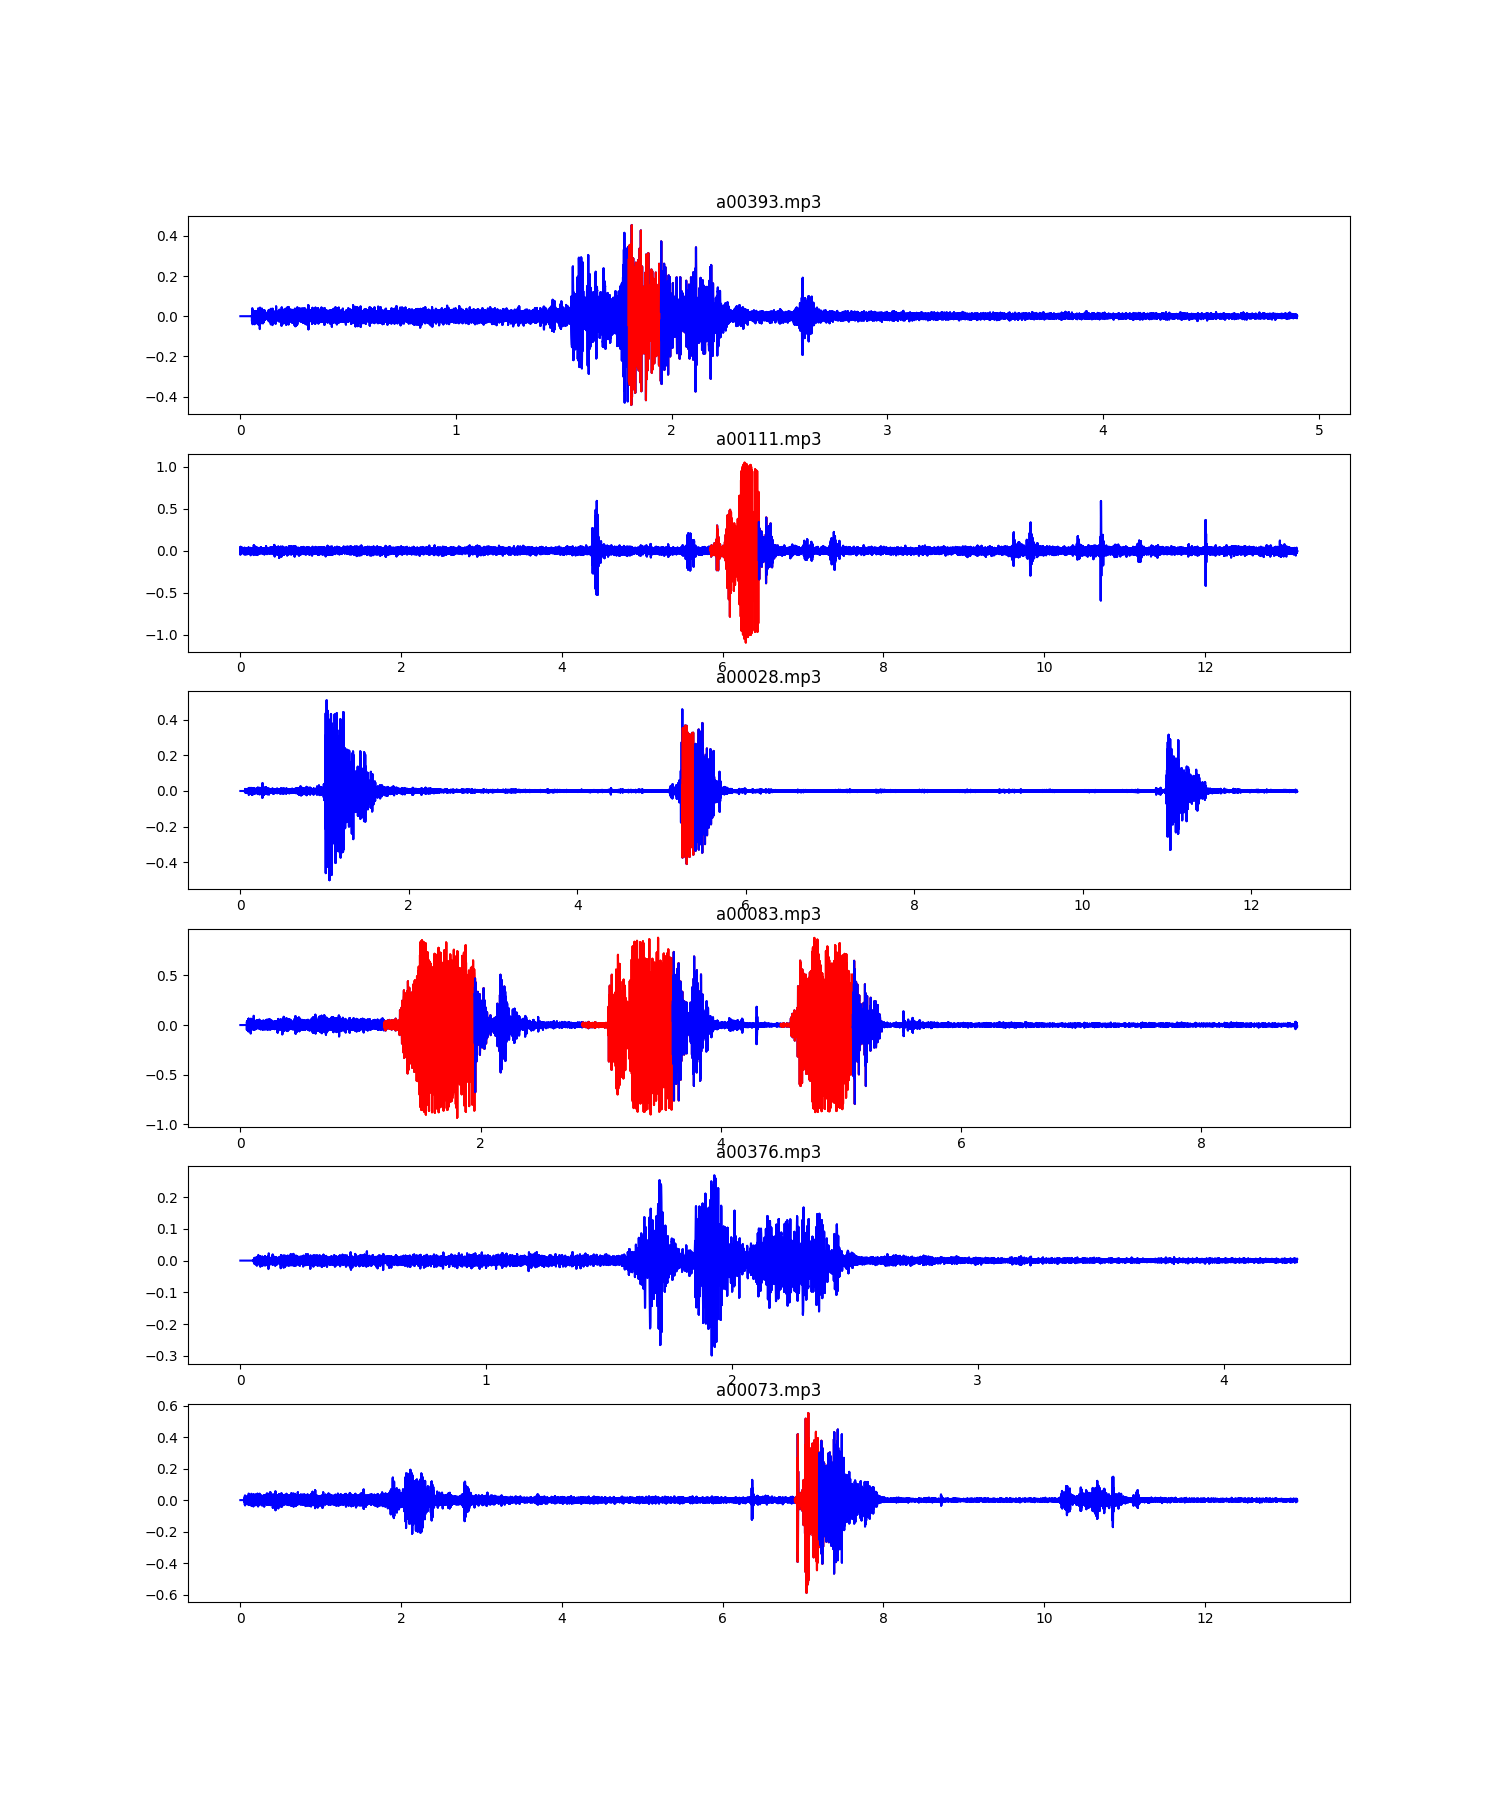

In [559]:
display(Image(filename='rnn_model_prediction.png'))

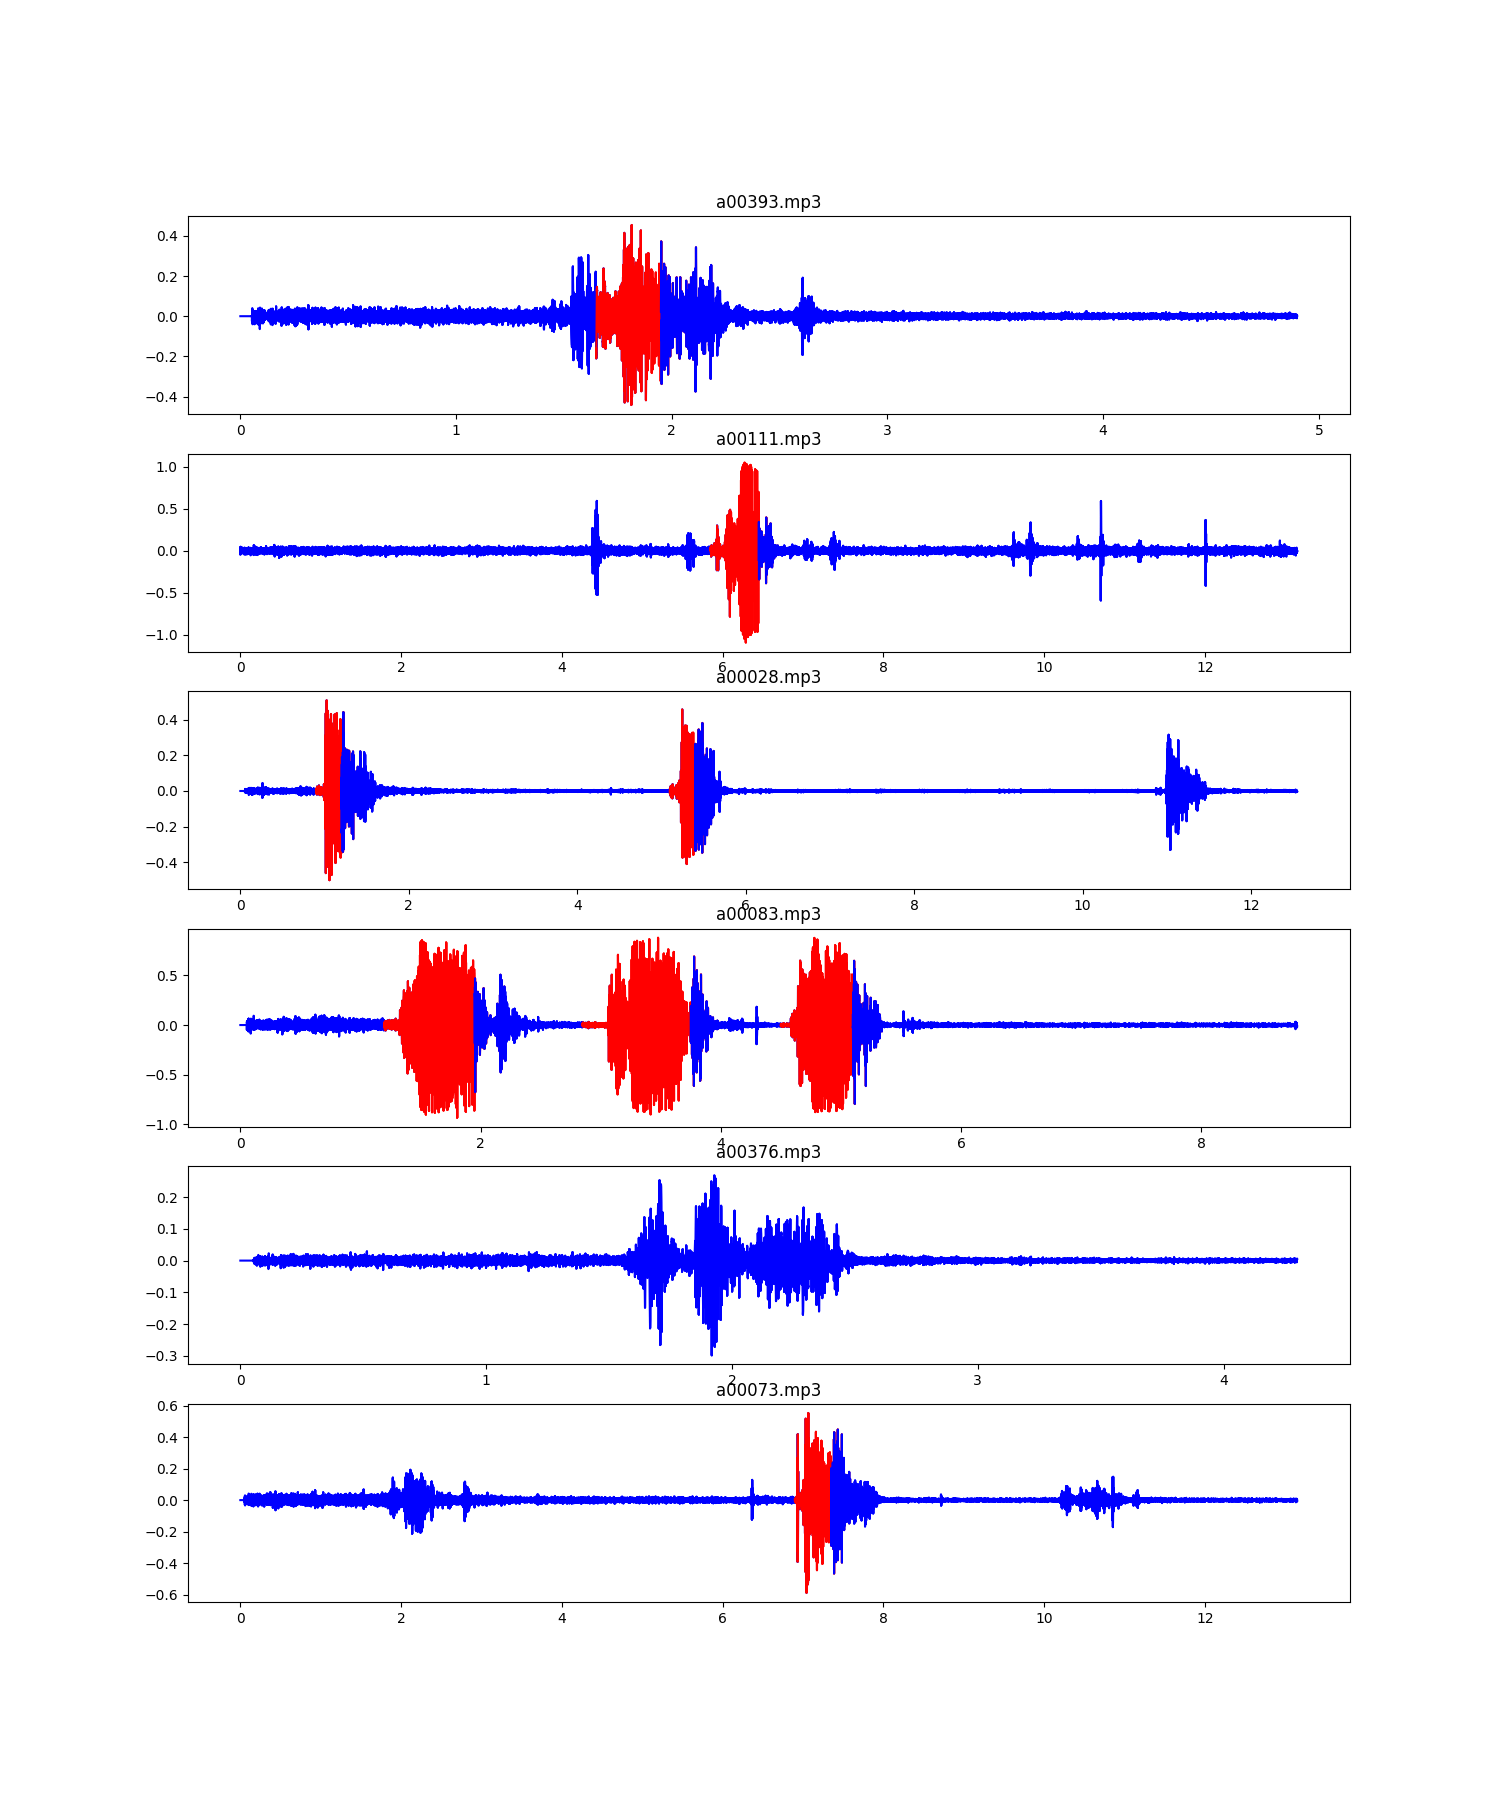

In [560]:
display(Image(filename='conv_model_prediction.png'))

**The idea was to classify the audio windows as swallowing periods or not, using some grouping technique or unsupervised learning, and with this classification train neural network models to generate the classification with new data.**
**Data augmentation was used, adding noise, time shift and inverting the audios, in an attempt to have a larger dataset to improve the generality of the models.**
**The LocalOutlierFactor model did well in 'detecting' the swallowing windows and created good labels.**
**I trained 3 neural network architectures, being an MLP, CNN and an RNN with LSTM block. I tried to find good parameters and hyperparameters, avoiding overfitting, and focusing on the validation f1 score. The 3 models improved in learning, with the convolutional one having the highest score for both classes 0 and 1.**
**The data are somewhat unbalanced, considering that there are many more windows that correspond to non-swallowing. I tried to use methods to artificially create data and balance the classes, but that generated some errors in training the networks. I believe it could be the wrong use of the lib, or the data is not appropriate for the techniques tested**